欠損値が少ないデータのみを抽出してモデルに学習させ、精度を確かめた。

In [ ]:
#必要なライブラリの読み込み
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import numpy as np
import MeCab
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
# pandasの設定変更
# 最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)
# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 50)
# 小数点以下の表示設定 (小数点以下2桁まで表示)
pd.options.display.float_format = '{0:<.2f}'.format

In [ ]:
#データの読み込み
df = pd.read_csv("C:\\Users\\syuhe\\Downloads\\prepared_cm-item-cm101 2.csv\\prepared_cm-item-cm101 2.csv", dtype=str, encoding='cp932')
df = df.loc[:, 'note':'price_remarks']
df.head()

,note,ownerIdentifier,subMaterialIdentifier,name,label,identifier,creator,dcterms:publisher,jpno,ndc,brand,schema:creator,datePublished,inLanguage,isPartOf,isbn,location,numberOfPages,position,provider,publisher,size,volumeNumber,alternateName,seriesName,productID,description,contentRating,version,originalWorkCreator,contributor,alternativeHeadline,ma:materialIdentifier,dcterms:creator,schema:publisher,price_int,price_tax_info,price_tax_included,price_remarks
0,1977/12/1,2,1,国立国会図書館,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,390,FALSE,NaN,NaN
1,2012/9/1,2,1,国立国会図書館,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,648,FALSE,NaN,NaN
2,2009/10/1,2,1,国立国会図書館,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900,TRUE,FALSE,NaN
3,2006/8/1,2,1,国立国会図書館,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,476,TRUE,FALSE,NaN
4,2004/4/1,2,1,国立国会図書館,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,660,TRUE,FALSE,NaN


In [ ]:
# price_int列とlabel列が欠損していない行を抽出する
#label列（マンガのタイトル）があるデータは比較的他のデータもそろっているため。
df = df.dropna(subset=['price_int', 'label'])

In [ ]:
'''
#出版社ごとに特徴があるようなので分ける
# publisher列の文字列データをOne-Hot Encodingして、新しい列を追加
df['extracted_publisher'] = df['publisher'].str.split('∥').str[0].str.strip()
# ダミー変数を作成する
one_hot_encoded = pd.get_dummies(df['extracted_publisher'],drop_first=True)

# 各列を 1 または 0 に置き換える
one_hot_encoded = one_hot_encoded.apply(lambda x: x.astype(int))
    
#元のDataFrameに新しい列を結合
df = pd.concat([df, one_hot_encoded], axis=1)
'''

"\n#出版社ごとに特徴があるようなので分ける\n# publisher列の文字列データをOne-Hot Encodingして、新しい列を追加\ndf['extracted_publisher'] = df['publisher'].str.split('∥').str[0].str.strip()\n# ダミー変数を作成する\none_hot_encoded = pd.get_dummies(df['extracted_publisher'],drop_first=True)\n\n# 各列を 1 または 0 に置き換える\none_hot_encoded = one_hot_encoded.apply(lambda x: x.astype(int))\n    \n#元のDataFrameに新しい列を結合\ndf = pd.concat([df, one_hot_encoded], axis=1)\n"

In [ ]:
#データの数
len(df)

44419

In [ ]:
# 最初の370000件を訓練データとして、残りをテストデータとして分割
train_data = df.iloc[:30000]
test_data = df.iloc[30000:]
print("訓練データは{}件、テストデータは{}件".format(len(train_data), len(test_data)))

訓練データは30000件、テストデータは14419件


特徴量の作成

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
def preprocessing(df):
    #出版地が東京であるものとそれ以外
    df['is_tokyo'] = (df['location'] == '東京').astype(int)
    
    #言語が日本語であるものとそれ以外
    df['is_Japanese'] = (df['inLanguage'] == '日本語').astype(int)
    
    df['contentRating'] = (df['contentRating'].isna()).astype(int)
    
    
    # 「label」列の単語数をカウントする関数を定義
    # MeCabを初期化
    mecab = MeCab.Tagger()

    # 形態素解析を行う関数を定義
    def count_words(text):
        word_count = 0
        node = mecab.parseToNode(text)
        while node:
            if node.surface != "":
                word_count += 1
            node = node.next
        return word_count   
    
    # DataFrameに新しい列として単語数を追加
    df['title_word_count'] = df['label'].apply(lambda x: x if isinstance(x, str) else '').apply(count_words).astype(int)
    
    # 'label' 列の各要素を文字列に変換する
    df['label'] = df['label'].astype(str)
    
    # 'label'列のデータ型を文字列型に変換する
    df['label'] = df['label'].astype(str)

    # BERTモデルの読み込み
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()

# テキストデータのベクトル化関数の定義
    def get_bert_embeddings(text):
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
    
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    
    # 'label'列のテキストデータをベクトル化してリストに変換
    bert_vectors = df['label'].map(get_bert_embeddings).tolist()

# ベクトルの各要素をそれぞれ新しい列としてDataFrameに追加
    for i in range(len(bert_vectors[0])):
        df[f'bert_vector_{i}'] = [vector[i] for vector in bert_vectors]

    
    # 'label' 列の文字数を計算して新しい列 'label_length' として追加する
    df['label_length'] = df['label'].apply(len)

    #作者の単語数を追加
    df['creator_word_count'] = df['creator'].apply(lambda x: x if isinstance(x, str) else '').apply(count_words).astype(int)
    
    # 'creator' 列の各要素を文字列に変換する
    df['creator'] = df['creator'].astype(str)
    
    # 'creator' 列の文字数を計算して新しい列 'creator_length' として追加する
    df['creator_length'] = df['creator'].apply(len)
    
    # 'version'列の値が欠損値であるかどうかを確認し、新しい列を作成
    df['version'] = (df['version'].isna()).astype(int)
    
    #数値データ
    # ページ数
    df['numberOfPages'] = df['numberOfPages'].str[:3]
    df['numberOfPages'] = df['numberOfPages'].str.extract(r'(\d{3})')
    df['numberOfPages'] = pd.to_numeric(df['numberOfPages'], errors='coerce')

    
    # サイズ
    # サイズ列を文字列に変換
    df['size'] = df['size'].astype(str)
    
    # 'size' 列に '+' が含まれているかどうかを調べ、2値化する列 'size_has_plus' を追加する
    df['size_has_plus'] = df['size'].apply(lambda x: 1 if '+' in x else 0)

    # 先頭の小数点を含めて3桁までの数字を抽出
    df['size'] = df['size'].apply(lambda x: re.search(r'\d+(\.\d{1,2})?', x).group(0) if re.search(r'\d+(\.\d{1,2})?', x) else None)

    # 抽出した数字を数値データに変換
    df['size'] = pd.to_numeric(df['size'], errors='coerce')
    
    # 巻数
    df['volumeNumber'] = df['volumeNumber'].apply(lambda x: re.sub(r'\D', '', str(x)))  # ここでは文字列に変換してから正規表現を適用
    df['volumeNumber'] = pd.to_numeric(df['volumeNumber'], errors='coerce')
    
    # ' を削除
    df.replace("'", '', regex=True, inplace=True)
    
    # 数値データをfloat64に変換
    df['numberOfPages'] = df['numberOfPages'].astype(float)
    df['price_int'] = df['price_int'].astype(float)
    
    #descriptionに初出が含まれているかいないか
    df['description'] = df['description'].astype(str)
    # '初出' を含むかどうかを示す列を作成する
    df['has_first_appearance'] = df['description'].str.contains('初出')

    # NaN を 0 で置き換える
    df['has_first_appearance'] = df['has_first_appearance'].fillna(0)

    # 'has_first_appearance' 列の値を 1 または 0 に変換する
    df['has_first_appearance'] = df['has_first_appearance'].astype(int)
    
    # 'note'列のデータを文字列型に変換
    df['note'] = df['note'].astype(str)

    # 'note'列の日付をパース
    df['parsed_date'] = pd.to_datetime(df['note'], errors='coerce')
     
    df['datePublished'] = pd.to_datetime(df['datePublished'], errors='coerce')
    
    # 年、月、日の特徴量を抽出
    df['year'] = df['parsed_date'].dt.year
    df['month'] = df['parsed_date'].dt.month
    df['day'] = df['parsed_date'].dt.day

    # 曜日の特徴量を抽出
    df['weekday'] = df['parsed_date'].dt.weekday

    # 季節の特徴量を抽出
    def get_season(month):
        if 3 <= month <= 5:
            return 1
        elif 6 <= month <= 8:
            return 2
        elif 9 <= month <= 11:
            return 3
        else:
            return 4

    df['season'] = df['month'].apply(get_season)

    # 出版日からの経過日数を計算
    current_date = pd.to_datetime('now')
    df['days_since_published'] = (current_date - df['datePublished']).dt.days
    
    
    #税に関する情報
    df['price_tax_info'] = df['price_tax_info'].replace({'TRUE': 1, 'FALSE': 0})
    df['price_tax_included'] = df['price_tax_included'].replace({'TRUE': 1, 'FALSE': 0})
    
    #その他よくわからないけど正答率を高めた特徴量
    df['ownerIdentifier']=df['ownerIdentifier'].fillna(0).astype(int)
    df['subMaterialIdentifier']=df['subMaterialIdentifier'].fillna(0).astype(int)
    
    binary_fetures=[
    'is_tokyo','is_Japanese','contentRating','version','has_first_appearance','price_tax_info','price_tax_included'
    ]

    numerical_columns=[
    'title_word_count','label_length','creator_word_count','creator_length','numberOfPages','season','ownerIdentifier','subMaterialIdentifier'
    ]
    # 2値データの欠損値を0で補完
    df[binary_fetures] = df[binary_fetures].fillna(0)
    
    scaler.fit(df['title_word_count','numberOfPages','version','days_since_published','ownerIdentifier','subMaterialIdentifier','volumeNumber','size'])
    
    #消すカラム
    df = df.drop(columns={'volumeNumber','description','note','name','identifier','creator','dcterms:publisher','jpno'})
    df = df.drop(columns={'ndc','brand','schema:creator','datePublished','inLanguage','isPartOf','isbn','location','provider','alternateName','seriesName','productID','originalWorkCreator','contributor'})
    df = df.drop(columns={'alternativeHeadline','parsed_date','ma:materialIdentifier','dcterms:creator','schema:publisher','publisher','position','price_remarks'})
    
    
    # 'price_int'列が50円より大きく1000円未満の行を削除(外れ値の削除)
    df = df[df['price_int'] < 1000]
    df = df[df['price_int'] > 50]
    
    
    return df

In [ ]:
train_df1 = preprocessing(train_data)
test_df1 = preprocessing(test_data)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

In [ ]:
train_df1 = train_df1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df1 = test_df1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# 重複する特徴量を削除する
train_df1 = train_df1.loc[:,~train_df1.columns.duplicated()]
test_df1 = test_df1.loc[:,~test_df1.columns.duplicated()]

In [ ]:
# 重複する特徴量を削除する
train_df1=train_df1.drop(columns={'label'})
test_df1=test_df1.drop(columns={'label'})

In [ ]:
train_df1

,ownerIdentifier,subMaterialIdentifier,numberOfPages,size,contentRating,version,price_int,price_tax_info,price_tax_included,is_tokyo,is_Japanese,title_word_count,bert_vector_0,bert_vector_1,bert_vector_2,bert_vector_3,bert_vector_4,bert_vector_5,bert_vector_6,bert_vector_7,bert_vector_8,bert_vector_9,bert_vector_10,bert_vector_11,bert_vector_12,...,bert_vector_754,bert_vector_755,bert_vector_756,bert_vector_757,bert_vector_758,bert_vector_759,bert_vector_760,bert_vector_761,bert_vector_762,bert_vector_763,bert_vector_764,bert_vector_765,bert_vector_766,bert_vector_767,label_length,creator_word_count,creator_length,size_has_plus,has_first_appearance,year,month,day,weekday,season,days_since_published
92673,0,0,NaN,18.00,1,1,390.00,0,0.00,1,1,4,-0.15,-0.91,0.06,-0.31,-0.69,-0.36,0.33,0.30,-0.39,-0.19,0.09,-0.22,0.16,...,0.54,0.17,-0.46,-0.57,-0.11,-0.13,-0.02,-0.24,-0.11,-0.76,0.30,0.07,0.14,-0.82,12,16,42,0,0,NaN,NaN,NaN,NaN,4,12179.00
92674,0,0,178.00,17.30,1,1,350.00,0,0.00,0,0,2,0.28,-0.81,-0.15,-0.47,-0.51,-0.13,0.29,-0.10,-0.44,0.36,0.33,-0.04,0.29,...,0.70,-0.18,0.09,0.02,-0.26,-0.24,0.05,-0.14,0.05,-0.59,0.47,-0.02,0.38,-1.00,7,33,85,0,0,NaN,NaN,NaN,NaN,4,15955.00
92676,0,0,186.00,18.00,1,1,360.00,0,0.00,1,1,4,-0.01,-0.87,-0.30,-0.53,-0.59,-0.15,0.24,0.02,-0.27,-0.01,0.27,-0.22,0.03,...,0.46,-0.05,-0.31,-0.56,-0.06,-0.13,0.03,0.03,0.29,-0.53,0.30,-0.24,0.24,-0.70,8,16,42,0,0,NaN,NaN,NaN,NaN,4,12840.00
92677,0,0,192.00,18.00,1,1,370.00,0,0.00,1,1,4,-0.05,-0.76,-0.20,-0.38,-0.62,-0.16,0.49,-0.14,-0.29,-0.04,0.19,0.01,0.39,...,0.52,-0.31,0.02,-0.06,-0.36,-0.31,0.19,-0.04,0.05,-0.61,0.31,-0.20,0.09,-0.84,10,16,42,0,0,NaN,NaN,NaN,NaN,4,13673.00
92678,0,0,180.00,18.00,1,1,360.00,0,0.00,1,1,3,-0.09,-1.11,0.33,-0.11,-0.51,-0.17,0.40,0.27,-0.22,0.34,0.27,-0.27,0.40,...,0.39,-0.10,-0.19,-0.15,-0.13,-0.06,-0.32,-0.28,0.09,-0.90,0.37,-0.13,0.16,-0.97,7,16,42,0,0,NaN,NaN,NaN,NaN,4,13154.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336900,0,0,218.00,18.00,1,1,690.00,0,0.00,1,1,7,-0.05,-0.75,0.03,-0.25,-0.69,-0.24,0.18,-0.14,-0.16,0.07,0.17,-0.25,0.21,...,0.20,0.00,-0.37,-0.36,-0.04,-0.15,0.10,-0.12,0.07,-0.60,0.06,-0.22,0.21,-0.48,24,10,19,0,0,NaN,NaN,NaN,NaN,4,-1.00
336901,0,0,187.00,18.00,1,1,454.00,0,0.00,1,1,10,0.05,-0.89,-0.00,-0.20,-0.48,-0.09,0.22,0.09,-0.22,0.30,0.17,-0.34,0.22,...,0.21,-0.33,-0.25,-0.39,-0.11,-0.25,0.06,-0.15,-0.13,-0.90,0.35,-0.22,0.28,-0.28,28,5,7,0,0,NaN,NaN,NaN,NaN,4,-1.00
336902,0,0,155.00,18.00,1,1,450.00,0,0.00,1,1,6,0.46,-0.74,0.11,-0.20,-0.47,0.01,0.28,-0.07,-0.31,0.45,0.16,-0.12,-0.00,...,0.40,-0.00,-0.27,-0.01,-0.34,0.10,-0.20,0.14,0.20,-0.08,0.01,-0.09,0.20,-0.33,36,10,18,0,0,NaN,NaN,NaN,NaN,4,-1.00
336904,0,0,161.00,19.00,1,1,650.00,0,0.00,1,1,13,-0.05,-0.53,0.29,-0.22,-0.35,-0.42,0.50,-0.33,-0.38,-0.20,0.25,0.15,0.67,...,0.43,-0.07,-0.29,-0.43,-0.18,-0.50,0.26,-0.32,0.05,-1.17,0.57,0.01,0.29,-0.98,21,16,36,0,0,NaN,NaN,NaN,NaN,4,-1.00


モデルの訓練

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae


col = "price_int"
for feature in train_df1.columns:
    if train_df1[feature].dtype == 'object':
        train_df1[feature] = train_df1[feature].astype('category')
    elif train_df1[feature].dtype == 'series':
        train_df1[feature] = train_df1[feature].astype('category')

train_y = train_df1[col]
train_x = train_df1.drop(columns={col})

trains = lgb.Dataset(train_x, train_y)

params = {
    "objective": "regression",
    "metrics": "mae"
}

model = lgb.train(params, trains,num_boost_round=1000)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196746
[LightGBM] [Info] Number of data points in the train set: 27723, number of used features: 787
[LightGBM] [Info] Start training from score 567.139054


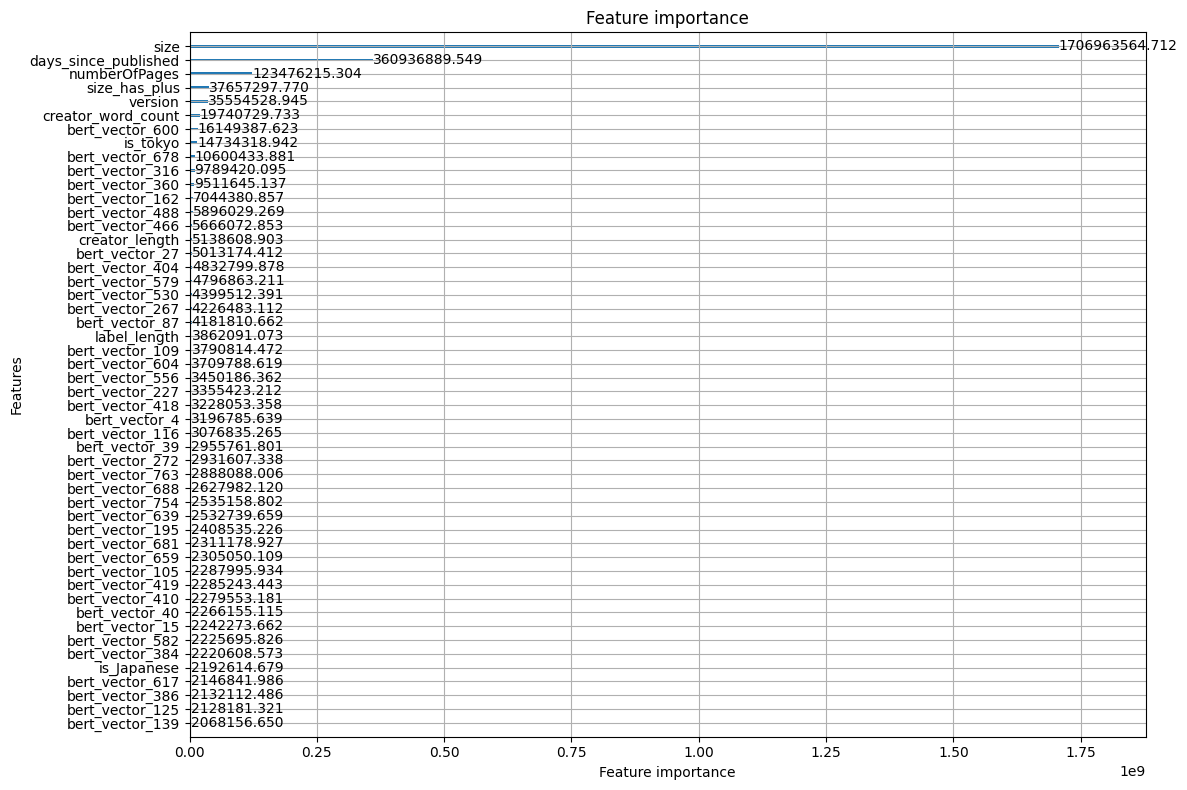

In [ ]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
print("訓練データは{}件、テストデータは{}件".format(len(train_df1), len(test_df1)))
#訓練データとテストデータの数的に過学習は防げていて汎用性の高いモデルになっているだろう。

訓練データは27723件、テストデータは13236件


In [ ]:
# テストデータから目的変数を取り除く
test_X = test_df1.drop(columns={'price_int'})

# テストデータの目的変数
test_y = test_df1['price_int']

In [ ]:
#lightGBMのテストデータでの予測
pred_y1 = model.predict(test_X)

In [ ]:
# 実測値と予測値の平均絶対誤差を算出する関数
def MAE(y_true,y_pre):
  return np.mean(np.abs(y_true-y_pre))

#lightGBM
MAE(test_y,pred_y1)

48.31251148422372

In [ ]:
#正答率の測定
eval_df = pd.DataFrame(list(zip(test_y ,pred_y1)), columns = ['価格','予測価格'])
eval_df["差分"] = np.abs(eval_df["価格"] - eval_df["予測価格"])
eval_df["50円以内の誤差"] = eval_df["差分"] <= 50
accuracy = (eval_df["50円以内の誤差"] == True).sum() / len(eval_df)
print(f"正答率：{accuracy}")

正答率：0.7263523723179208


In [ ]:
eval_df

,価格,予測価格,差分,50円以内の誤差
0,670.00,651.02,18.98,True
1,454.00,485.29,31.29,True
2,440.00,456.26,16.26,True
3,454.00,463.86,9.86,True
4,720.00,665.01,54.99,False
...,...,...,...,...
13231,660.00,634.80,25.20,True
13232,660.00,663.09,3.09,True
13233,600.00,622.38,22.38,True
13234,650.00,677.36,27.36,True
